In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install transformers

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn

import transformers
from sklearn.metrics import *
from transformers import AdamW
from tqdm.notebook import tqdm
from scipy.special import softmax
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split as tts
from transformers import BertTokenizerFast, BertTokenizer, BertModel, BertConfig, BertForSequenceClassification, AutoModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
cd drive/My Drive/Colab Notebooks/experiments

/content/drive/My Drive/Colab Notebooks/experiments


In [ ]:
# Download humor detection data
# Paper: https://arxiv.org/abs/2004.12765
data = pd.read_csv("data/moh-x.csv")
print("\nThere are", len(data), "sentences")

# Use the standard text/label columns
# Create labels: 1 --> humorous, 0 --> not humorous
data["label"] = data["label"].apply(int)
data.head()


There are 647 sentences


,arg1,arg2,verb,sentence,verb_idx,label
0,knowledge,NaN,absorb,He absorbed the knowledge or beliefs of his t...,1,1
1,cost,NaN,absorb,He absorbed the costs for the accident .,1,1
2,tax,NaN,absorb,The sales tax is absorbed into the state inco...,4,1
3,immigrant,NaN,absorb,The immigrants were quickly absorbed into soc...,4,1
4,interest,NaN,absorb,Her interest in butterflies absorbs her compl...,4,1


In [ ]:
# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased").to(device)
model.eval()

# Tokenize text and convert to ids.
input_ids = torch.tensor([tokenizer.encode(data.iloc[0].sentence, add_special_tokens=True)]).to(device)
print(input_ids)
tokenized_text = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokenized_text)


tensor([[ 101, 2002, 9063, 1996, 3716, 2030, 9029, 1997, 2010, 5917, 1012,  102]])
['[CLS]', 'he', 'absorbed', 'the', 'knowledge', 'or', 'beliefs', 'of', 'his', 'tribe', '.', '[SEP]']


In [ ]:
# Use a subset for quick experiments
#subset_data = data[:10000]

# Split to train, val and test
train, test = tts(data[["sentence", "label"]], random_state=42, test_size=0.1)
train, val = tts(train, random_state=42, test_size=test.shape[0])

In [ ]:
!ls -a

bert		    models			  saved_weights.pt
cache_dir	    multilingual		  stockholm
data		    norm-analysis-of-transformer  transfer_learning
.ipynb_checkpoints  preprocessing		  Transformer-Explainability
log		    reports			  uncased_L-12_H-768_A-12.zip
model		    run_language_modeling.py	  uncased_L-12_H-768_A-12.zip.1


In [ ]:
cd norm-analysis-of-transformer/transformers

/content/drive/My Drive/Colab Notebooks/experiments/norm-analysis-of-transformer/transformers


In [ ]:
!pip install -e .

Obtaining file:///content/drive/My%20Drive/Colab%20Notebooks/experiments/norm-analysis-of-transformer/transformers
  Found existing installation: transformers 3.0.0
    Can't uninstall 'transformers'. No files were found to uninstall.
  Running setup.py develop for transformers


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
with torch.no_grad():
    last_hidden_state, pooler_output, hidden_states, attentions, norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)

In [ ]:
# Returned variable "norms" is a tuple which has 12 elements (equal to the number of layers).
print(type(norms))
print(len(norms))

<class 'tuple'>
12


In [ ]:
# Each element is a tuple which consists of 3 elements: ||f(x)||, ||αf(x)||, and ||Σαf(x)||.
layer = 5
print(type(norms[layer-1]))
print(len(norms[layer-1]))

fx_norm, afx_norm, summed_afx_norm = norms[layer-1]

<class 'tuple'>
3


In [ ]:
# shape of fx_norm (||f(x)||) is (batch, num_heads, seq_length)
print("shape of ||f(x)||:", fx_norm.size())

shape of ||f(x)||: torch.Size([1, 12, 12])


In [ ]:
# shape of afx_norm (||αf(x)||) is (batch, num_heads, seq_length, seq_length)
print("shape of ||αf(x)||:", afx_norm.size())

shape of ||αf(x)||: torch.Size([1, 12, 12, 12])


In [ ]:
# shape of summed_afx_norm (||Σαf(x)||) is (batch, seq_length, seq_length)
print("shape of ||Σαf(x)||:", summed_afx_norm.size())

shape of ||Σαf(x)||: torch.Size([1, 12, 12])


###Comparison with Attention Weight

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set the layer and head you want to check. (layer: 1~12, head: 1~12)
layer = 4
head = 12

##Test 1

In [ ]:
# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased").to(device)
model.eval()

# Tokenize text and convert to ids.
input_ids = torch.tensor([tokenizer.encode(str(test.iloc[0].sentence), add_special_tokens=True)]).to(device)
print(input_ids)
tokenized_text = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokenized_text)

tensor([[  101,  2002,  9847,  2046,  1996,  9823,  1998,  2623,  1996, 11360,
          1012,   102]])
['[CLS]', 'he', 'marched', 'into', 'the', 'classroom', 'and', 'announced', 'the', 'exam', '.', '[SEP]']


In [ ]:
with torch.no_grad():
    last_hidden_state, pooler_output, hidden_states, attentions, norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)

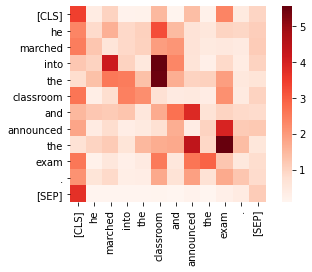

In [ ]:
# Norm of the summed weighted vectors (||Σ αf(x)||) visualization (Layer-level visualization)
plt.figure() 
summed_afx_norm = norms[layer-1][2]
norm = summed_afx_norm[0].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

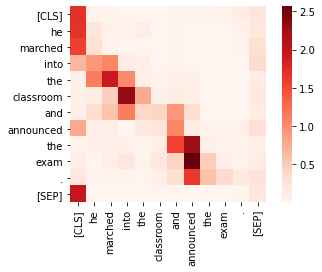

In [ ]:
# Norm of the weighted vectors (||αf(x)||) visualization (Head-level visualization)
plt.figure() 
afx_norm = norms[layer-1][1]
norm = afx_norm[0][head-1].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

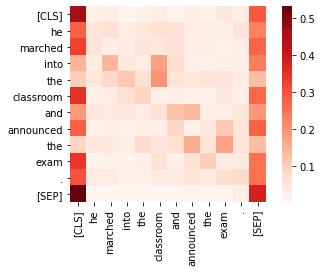

In [ ]:
# Attention weight visualization (Layer-level visualization)
plt.figure() 
attention = attentions[layer-1][0].mean(0).cpu().numpy()
df = pd.DataFrame(attention,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

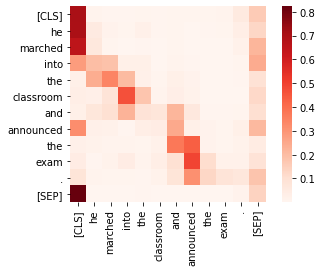

In [ ]:
#Attention weight visualization (Head-level visualization)
plt.figure() 
attention = attentions[layer-1][0][head-1].cpu().numpy()
df = pd.DataFrame(attention,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

##Test 2

In [ ]:
# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased").to(device)
model.eval()

# Tokenize text and convert to ids.
input_ids = torch.tensor([tokenizer.encode(str(test.iloc[1].sentence), add_special_tokens=True)]).to(device)
print(input_ids)
tokenized_text = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokenized_text)

tensor([[  101,  1996,  3340, 24665, 18891, 12259,  2875,  2169,  2060,  1012,
           102]])
['[CLS]', 'the', 'stars', 'gr', '##avi', '##tate', 'towards', 'each', 'other', '.', '[SEP]']


In [ ]:
with torch.no_grad():
    last_hidden_state, pooler_output, hidden_states, attentions, norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)

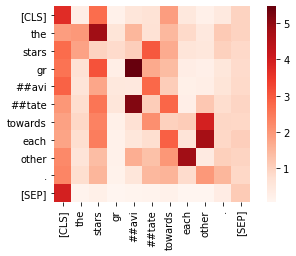

In [ ]:
# Norm of the summed weighted vectors (||Σ αf(x)||) visualization (Layer-level visualization)
plt.figure() 
summed_afx_norm = norms[layer-1][2]
norm = summed_afx_norm[0].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

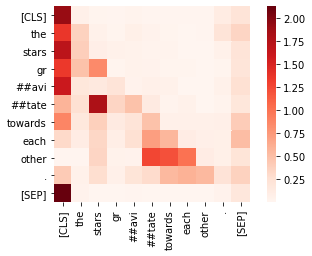

In [ ]:
# Norm of the weighted vectors (||αf(x)||) visualization (Head-level visualization)
plt.figure() 
afx_norm = norms[layer-1][1]
norm = afx_norm[0][head-1].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

##Test 3

In [ ]:
# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased").to(device)
model.eval()

# Tokenize text and convert to ids.
input_ids = torch.tensor([tokenizer.encode(str(test.iloc[2].sentence), add_special_tokens=True)]).to(device)
print(input_ids)
tokenized_text = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokenized_text)

tensor([[  101,  1037,  2980, 11350,  2097, 17995,  2033,  1012,   102]])
['[CLS]', 'a', 'hot', 'soup', 'will', 'revive', 'me', '.', '[SEP]']


In [ ]:
with torch.no_grad():
    last_hidden_state, pooler_output, hidden_states, attentions, norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)

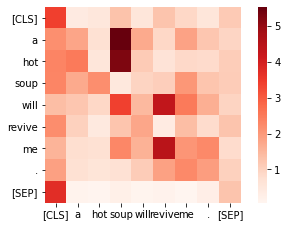

In [ ]:
# Norm of the summed weighted vectors (||Σ αf(x)||) visualization (Layer-level visualization)
plt.figure() 
summed_afx_norm = norms[layer-1][2]
norm = summed_afx_norm[0].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

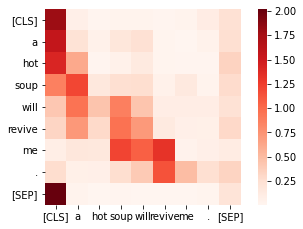

In [ ]:
# Norm of the weighted vectors (||αf(x)||) visualization (Head-level visualization)
plt.figure() 
afx_norm = norms[layer-1][1]
norm = afx_norm[0][head-1].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

##Test 4

In [70]:
# Tokenize text and convert to ids.
input_ids = torch.tensor([tokenizer.encode(str(test.iloc[3].sentence), add_special_tokens=True)]).to(device)
print(input_ids)
tokenized_text = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokenized_text)

tensor([[  101,  2002, 10570,  2023,  2806,  1997,  3850,  1012,   102]])
['[CLS]', 'he', 'revived', 'this', 'style', 'of', 'opera', '.', '[SEP]']


In [71]:
with torch.no_grad():
    last_hidden_state, pooler_output, hidden_states, attentions, norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)

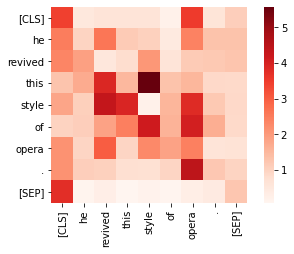

In [72]:
# Norm of the summed weighted vectors (||Σ αf(x)||) visualization (Layer-level visualization)
plt.figure() 
summed_afx_norm = norms[layer-1][2]
norm = summed_afx_norm[0].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

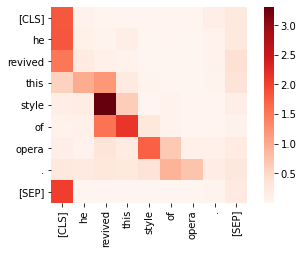

In [73]:
# Norm of the weighted vectors (||αf(x)||) visualization (Head-level visualization)
plt.figure() 
afx_norm = norms[layer-1][1]
norm = afx_norm[0][head-1].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)